In [ ]:
!unzip /content/drive/MyDrive/classification-of-short-noisy-audio-speech.zip

In [ ]:
!unzip /content/drive/MyDrive/filtered_classification-of-short-noisy-audio-speech.zip

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=f5b64e6218b0828c10ea9defa02100cddebfb1697e16ddd7d2cbab0c93c3dc7a
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
!pip install noisereduce

In [ ]:
!pip install pydub

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


from tensorflow import keras
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
from random import randint
import scipy.io.wavfile as wav
import numpy as np
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import noisereduce as nr
from pydub import AudioSegment as am

### Зашумление уже обработанных "чистых данных"

In [ ]:
noises = []
for filename in os.listdir('/content/hackaton_ds/noises'):
    sound = am.from_file('/content/hackaton_ds/noises/'+filename, format='wav')
    sound = sound.set_frame_rate(16000)
    sound = sound.set_channels(1)
    sound.export('file_trim_5s.wav', format='wav')  
    
    (rate,sig) = wav.read('file_trim_5s.wav')
    # print(rate)
    # print(sig)
    # print(np.max(sig))
    noises.append(sig)

In [ ]:
def make_some_noise(clean):
    max_amp = 1 - np.random.random() / 3
    noise = noises[np.random.randint(0, len(noises))]
    noise_amp = np.random.rand() * max_amp
    max_start = len(noise) - len(clean)
    start = np.random.randint(0, max_start + 1)
    noise_part = noise[start:start+len(clean)]
    noise_mult = np.abs(clean.max()) / np.abs(noise_part).max() * noise_amp
    return (clean + noise_part * noise_mult) / (1 + noise_amp)



In [ ]:
types = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

repeats = 8

datasize = 38546*repeats

X = np.zeros( (datasize, 99, 13), dtype="float32") 
Y = np.zeros( (datasize), dtype="int8") 

cnt = 0

dir = '/content/filtered/train/'

for i, word in enumerate(types):
  for filename in os.listdir(word):
    (rate,sig) = wav.read(dir+word+"/"+filename)
    l = len(sig)
    if l > 16000:
        sig = sig[:16000]
    elif l<16000:
        sig = np.pad(sig, (0, 16000-l), 'constant')

    for j in range(repeats):
      msk = make_some_noise(sig).astype('int16')
      cur = mfcc(msk,rate)
      
      X[cnt] = cur
      Y[cnt] = i
      cnt+=1


### Подготовка для обучения модели

In [ ]:
X = X.reshape(len(X), 99, 13, 1)
Y = Y.reshape(len(Y), 1)
 
x_train, x_test, y_train, y_test = train_test_split(
                                        X, Y,
                                        test_size=0.2,
                                        random_state=42,
                                    )

num_classes = 10
input_shape = (99, 13, 1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Архитектура модели

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = 'same', strides = (2,2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding = 'same', strides = (2,2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding = 'same', strides = (2,2)),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(256,activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
 
 
model.summary()

### Обучение модели

In [ ]:
from keras.callbacks import ReduceLROnPlateau

batch_size = 256
epochs = 200

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

checkpoint_filepath = 'weights.{epoch:02d}-{val_accuracy:.4f}.h5'
mcp_save = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')
#earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(x_train, y_train, batch_size=batch_size, callbacks = [mcp_save],  epochs=epochs, validation_split=0.1)

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


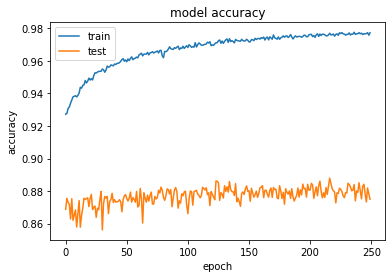

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/weights_104-0_9409.h5')

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 454.3836364746094
Test accuracy: 0.9767428636550903


### Make submission.csv


In [ ]:
test_path = '/content/hackaton_ds/test/'
test = []
file_names = []

pbar = tqdm(total=29620, position=0, leave=True)

for file_name in os.listdir(test_path):
    (rate,sig) = wav.read(test_path+file_name)
    file_names.append(file_name)

    file_mel = mfcc(sig,rate)

    tmp = np.zeros((99, 13))
    tmp[:file_mel.shape[0],:file_mel.shape[1]] = file_mel

    test.append(tmp)
    pbar.update(1)
    pbar.set_description(f"\Read {len(test)} phrazes")

\Read 1974 phrazes:   7%|▋         | 1974/29620 [06:32<1:34:08,  4.89it/s]/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:303: RuntimeWarning: invalid value encountered in true_divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
\Read 29620 phrazes: 100%|██████████| 29620/29620 [1:34:09<00:00,  5.41it/s]

In [ ]:
test = np.array(test)
test = test.reshape((len(test), 99, 13, 1))
predictions = model.predict(test)

In [ ]:
types = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [ ]:
file_names_ = ['' for i in range(len(file_names))]
for i in range(len(file_names)):
  file_names_[i] = file_names[i].split('.')[0]

In [ ]:
answer = []
for i in np.argmax(predictions, axis = -1):
    answer.append(types[i])

In [ ]:
df = pd.DataFrame({'id':file_names_, 'category':answer})
df.to_csv('submition.csv',index=False, sep=',', encoding='utf-8')